In [1]:
# I.
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import squarify 
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import re


In [2]:
# II

# Descargo tablas de referencia
lands = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/ldown_c.csv')
countries_ref = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/countries_ref.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [3]:
# III Merging the tables

# It's neccessary to merge the databases of lands(lands types) and world (geographic reference), 
# using countries_ref as a reference table, to obtain the main df with all the necessary data.

##########################################################
# The study is done just whith the data of the 2016 year #
##########################################################
lands = lands[lands.year==2016]

# Merge the three tables:
l_c = countries_ref.merge(lands,left_on='name_l', right_on='country')
w_l_c = world.merge(l_c,
                    left_on = world['name'].str.strip().str.lower(), 
                    right_on=l_c['name_w'].str.strip().str.lower()).drop(columns=['name', 'key_0'], axis=1)


# Replace the string of types in order of simplify their names
lrep = {'Land area (thousand hectares)':'LA',
        'Arable land (thousand hectares)': 'AL', 'Arable land (% of total land area)':'AL_%',
        'Forest cover (thousand hectares)':'FC', 'Forest cover (% of total land area)':'FC_%',
        'Permanent crops (thousand hectares)':'PC','Permanent crops (% of total land area)':'PC_%',
        'Important sites for terrestrial biodiversity protected (% of total sites protected)':'IB%'}

# Main df with al the data            
w_l_c['type'] = w_l_c['type'].map(lrep)

# IV
# Creating the dataframe to calcule the main indicators
AL = w_l_c[['name_l','name_w','pop_est','value', 'geometry', 'continent']][w_l_c['type']=='AL'].rename(columns={'value':'AL'}).reset_index(drop=True)
PC = w_l_c[['value']][w_l_c['type']=='PC'].rename(columns={'value':'PC'}).reset_index(drop=True)
LA = w_l_c[['value']][w_l_c['type']=='LA'].rename(columns={'value':'LA'}).reset_index(drop=True)

w_land = pd.concat([AL, PC, LA], axis=1, join='inner')

for name in ('name_w','name_l'):
    w_land[name] = w_land[name].str.strip()
    #w_land['name_l'] = w_land['name_l'].str.strip()


def noNaN(df,values):
    for v in values:
        df[values] = df[values].replace(np.nan, 0)
        return df[values]

noNaN(w_land,['AL','PC','LA'])

# V
# Creating the indicators:
# CL, CL%(AL + PC), 'pop_est%', 'density' and 'density_CL', HpF, ref, ind
w_land['CL']= w_land['AL']+w_land['PC']
w_land['CL%']= 100*w_land['CL']/w_land['LA']
w_land['pop_est%'] = 100* w_land['pop_est']/w_land['pop_est'].sum()
w_land['density'] = (w_land['pop_est']/4)/(0.1 + w_land['LA']*1000)
w_land['density_CL'] = (w_land['pop_est']/4)/(0.1+w_land['CL']*1000)

ref_val = 1 #---->> Ha Reference Value!!!!

w_land['HpF'] = (4000) * w_land['CL']/w_land['pop_est']
w_land['ref'] = w_land['HpF'] - ref_val
w_land = w_land.sort_values(by=['continent', 'ref']).reset_index(drop=True)
w_land['name_l']= w_land['name_l'].str.capitalize()
w_land['ind'] = w_land['HpF'].apply(lambda x: 'over' if x >=ref_val else 'under')

## Exceptions:
w_land = w_land[~w_land['name_w'].str.contains('falkland is.|n. cyprus')] 


KeyError: nan

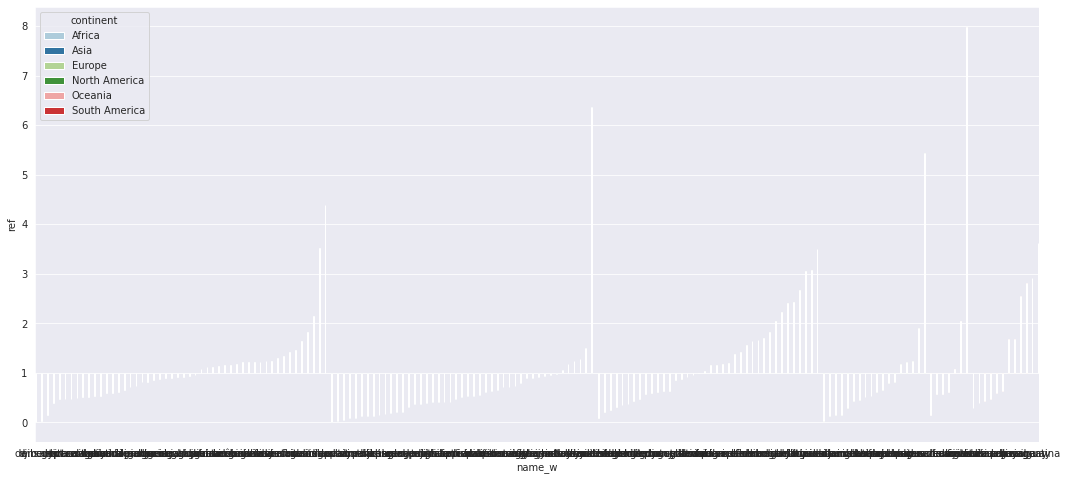

In [6]:
# XIII

# # SEABORN

plt.rcParams.update({'xtick.labelbottom':'on',
                    'ytick.labelleft':'on'})

fig= plt.figure(figsize=(18,8)) # width, height in inches -> 

with sns.axes_style("darkgrid"):
    bx = sns.barplot(x='name_w', y="ref", data=w_land, hue='continent', bottom=ref_val
                     , palette="Paired", edgecolor=None)

# Create the list of patches not nulls, for the x axis values.
def patches(bxs):
    patches_heights = []
    for n in range(len(bxs.patches)):
        if (bxs.patches[n].get_height() <0 or bxs.patches[n].get_height() >0):
            s = bxs.patches[n].get_x()
            patches_heights.append(s)
    patches_heights = pd.DataFrame(patches_heights, columns=['xaxis'])
    return(patches_heights)

pop_axis = pd.concat([w_land, patches(bx)], axis=1)

pop_axis['name_w'] = pop_axis['name_w'].replace('United states of america','USA') 

# Selection of the two first countries for every geo. region named in the plot
popg = pop_axis.groupby(['continent','name_w']).max()
popg = popg[['HpF', 'xaxis']].sort_values(by=['continent','HpF'], ascending=False)

l_pays = []
[l_pays.append(popg.loc[p][:2].index[s]) for s in range(2) for p in pop_axis['continent'].unique()]


# Function to chanche the with of the bars. Its necessary iterate over the patches values.
def change_width(bxs, new_value) : 
    for patch in bxs.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff)

width = 0.85
change_width(bx, width)

# Putting the names of the selected countrys in the plot
def text_c(df,bxs,t):
    ls = []
    if t=='mark':
        for n in l_pays:
            o = bxs.text(float(df['xaxis'][df['name_w']==n])-width, float(df['HpF'][df['name_w']==n]-0.15)
                     ,'\u25CF', fontweight='extra bold', rotation=0) #\u00B0 '\u03BF' , fontsize=30
            ls.append(o) 

    else:
        for n in l_pays:
            o = bxs.text(float(df['xaxis'][df['name_w']==n])-len(n)-1, float(df['HpF'][df['name_w']==n]-0.15)
                     ,n , rotation=0)
            ls.append(o)        
    return ls

text_c(pop_axis,bx,'mark')
text_c(pop_axis,bx,'name')


# Setting the figure 
bx.axhline(ref_val, color="darkslategray", lw=3, clip_on=False)

bx.tick_params(labelsize=12)
bx.set_xlabel("Countries", fontsize=20)
bx.set_ylabel("Ha per family", fontsize=20)

bx.set_xticklabels([bx.get_xticklabels()[n] for n in range(0,w_land.shape[0])], rotation=-90)
bx.set_xticks([bx.get_xticks()[n] for n in range(0, w_land.shape[0], 4)])

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='ultralight',
                                   style='normal', 
                                   stretch='ultra-condensed',
                                   size=14)

bx.legend(title='Geographic Region',loc= 'upper center',
          frameon=False, prop=font, title_fontsize='xx-large', ncol=6)

# In order to get the values every continent
pp = pop_axis.groupby(['continent', 'ind']).count()
pp = pp.reset_index(level=['ind']).pivot(columns='ind', values='LpP')
pp['total'] = pp['over']+pp['under']
lc = [(pp.loc[n][0], pp.loc[n][1]) for n in pop_axis.continent.unique()]

def text_sum(t1, t2, x, y):
    plt.text(x, y, ' '+t1+'\u2191\n '+t2 +'\u2193',
    fontsize=13, fontstyle='oblique',
    bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='black'))

        
text_sum(str(lc[0][0]), str(lc[0][1]), 22-3, 1.5)    
text_sum(str(lc[1][0]), str(lc[1][1]), 50+39-15, 2.5)
text_sum(str(lc[2][0]), str(lc[2][1]), 50+46+17-3, 2.5)
text_sum(str(lc[3][0]), str(lc[3][1]), 50+46+38+5, 3)
text_sum(str(lc[4][0]), str(lc[4][1]), 50+46+38+18+3-3, 4.5)
text_sum(str(lc[5][0]), str(lc[5][1]), 50+46+38+18+7+6-3, 5)


plt.tight_layout()

# # Show graphic

plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/ha_ref.png', bbox_inches='tight')


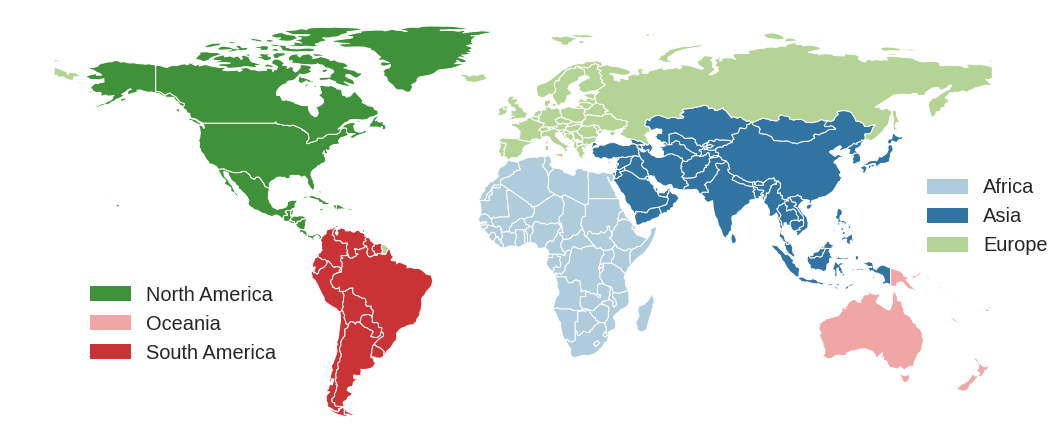

In [44]:
# XIV

# Taking the color reference of the previous plot

plt.rcParams.update({#'xtick.labelsize':15, 
                     #'ytick.labelsize':15,
                     'ytick.labelleft':'off',
                     'ytick.labelright':'off',
                     'xtick.labelbottom':'off',
                     'axes.spines.left': False,
                     'axes.spines.bottom' : False,
                     'axes.spines.top': False,
                     'axes.spines.right':False,
                     'ytick.left':False,
                     'xtick.bottom':False,
                     #'axes.ymargin': 0.5, 
                     #'axes.autolimit_mode': 'round_numbers',
                     #'axes.labelsize':16,
                     #'axes.grid':False,
                     #'axes.edgecolor':'slategrey'
                    })

def colors(bxs):
    patches_colors = []
    for n in range(len(bxs.patches)):
        if (bxs.patches[n].get_height() <0 or bxs.patches[n].get_height() >0):
            s = bxs.patches[n].get_facecolor()
            patches_colors.append([s])
    patches_colors = pd.DataFrame(patches_colors, columns=['color'])
    return(patches_colors)

pop_color = pd.concat([dclw, colors(bx)], axis=1)
c_list = pop_color['color'].unique()

# Creating/setting the plot
fig, cx1 = plt.subplots(1, 1, figsize=(15, 15))

pop_color = pop_color.to_crs("EPSG:4326")#3035")#"EPSG:")4326

cont_l = pop_color.continent.unique()

for c in range(len(cont_l)):
    cx1 = pop_color[pop_color["continent"] == cont_l[c]].plot(ax=cx1, color=c_list[c], 
                                        legend=True,
                                        edgecolor='white')

cx1.patch.set_facecolor('white')

## Adding the legend
patchList = []
for k in range(len(pop_color['color'].unique())):
        data_color = mpatches.Patch(color=pop_color['color'].unique()[k], 
                                  label=pop_color['continent'].unique()[k])
        patchList.append(data_color)


l1 = plt.legend(handles=patchList[3:6], ncol=1, loc='lower center', bbox_to_anchor=(0.17,0.13), fontsize=20)
l2 = plt.legend(handles=patchList[:3], ncol=1, loc='lower center', bbox_to_anchor=(0.95,0.38), fontsize=20)
plt.gca().add_artist(l1)

plt.tight_layout()

plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/world_map.png', bbox_inches='tight')
plt.show()
